# Something Awesome: QKD-Rijndael Integrator
#### Aarya Bodhankar | z5437970 | COMP6841 [23T3]

<!-- 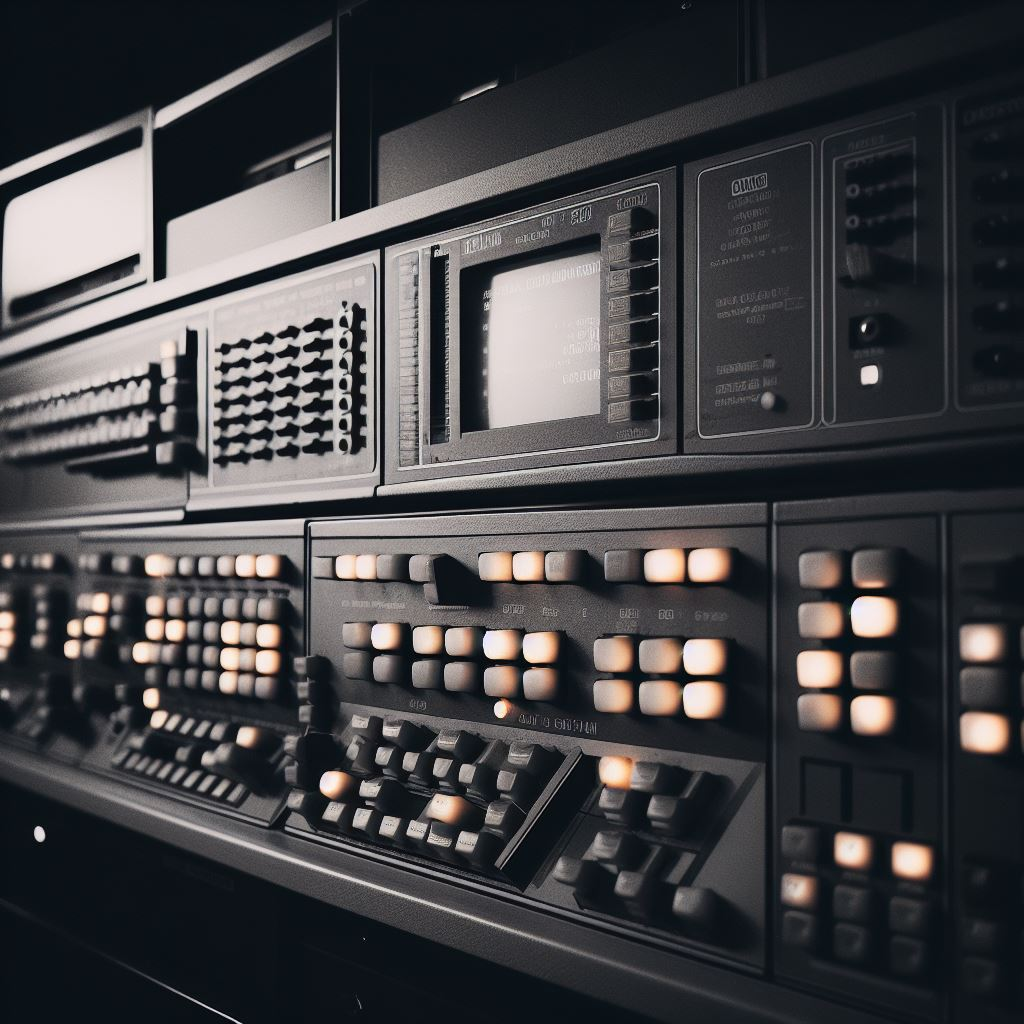 -->
<img src="https://media.discordapp.net/attachments/590611990506897474/1170668314947760149/OIG.png" width="200">
<sup style="color:gray;">Source: DALL.E 3</sup>

## Premise
While RSA, and more recently ECDH, remain the predominant standards for securing dta over the internet, the Advanced Encryption Standard or AES, based on the Rijndael Cipher, is the world's most heavily used cryptographic standard for sensitive operations. Largely used in the 128-bit key size, today's systems are increasingly moving towards 256-bit configurations. This makes it essential to safeguard and keep the standard up to date with the latest security techniques.

## Threats
As of November 2023, AES remains uncracked and reliable, but it is a symmetric cipher which relies upon both parties having possession of the key. For communication involving remote correspondence, this then necessitates transmitting the key itself securely. The age-old paradigm of _'a cipher is only as secure as its key'_. Since the bulk of operations take place over the internet, this then implies that the key is transmitted using RSA or ECDH, thereby making the channel less secure than AES itself.

Of course, this problem does not arise if the keys have been exchanged prior to the use of the current channel, but that is not the norm and can't be depended upon in all scenarios.

<!-- 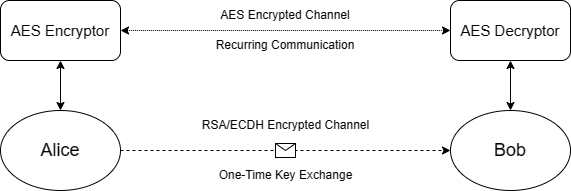 -->
<!-- 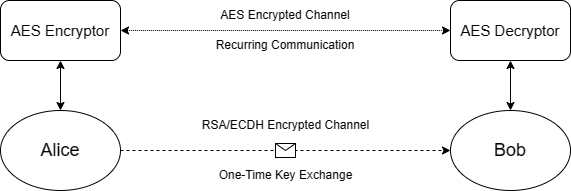 -->

<!-- 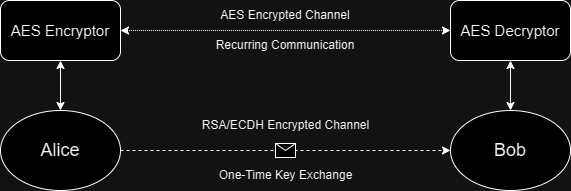 -->
<img src="https://media.discordapp.net/attachments/590611990506897474/1170669021411160204/AESFlowchart.png" width="450">
<sup style="color:gray">Source: Aarya Bodhankar</sup>

## Solution
While there is no way to secure the channel without making use of another algorithm which comes with its own challenges.  The next closest solution is to make the key tamper-evident, meaning that both parties will know if an intermediate party conducted a man-in-the-middle or MITM attack, thereby compromising the key. One of the most advanced methods to do this is via Quantum Key Distribution or QKD. It relies upon the quantum property of qubits, which are the quantum equivalent of bits, changing their state when read, or in quantum terms: measured. What this means is that both parties will know that the qubits have changed before they measured it, thereby alerting them to a compromised channel.

This is only applicable if the attacker actually measures the qubits, but it is assumed that having access to the channel without touching the keys is a fruitless endeavour.

<!-- 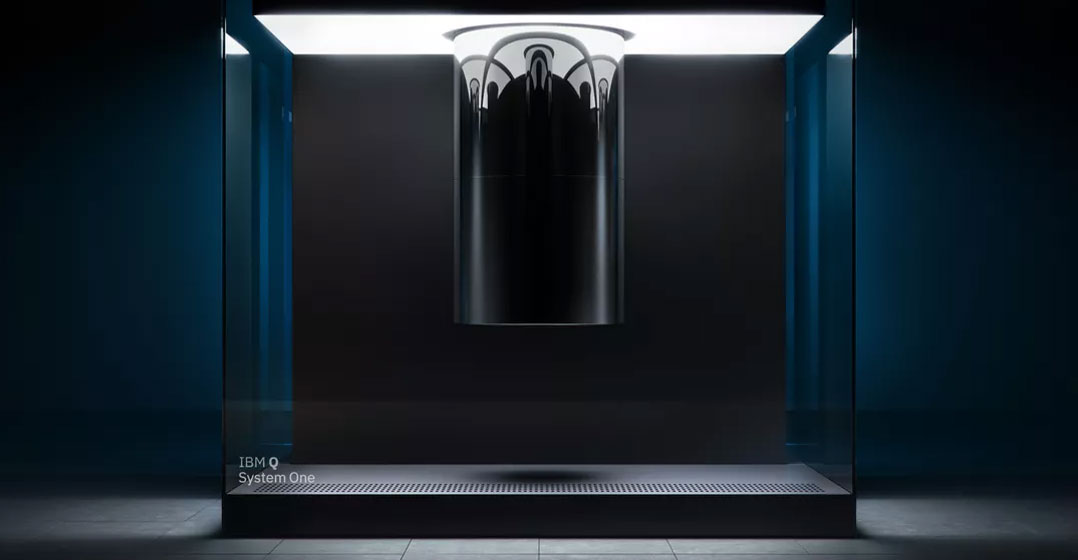![image.png] -->
<img src="https://research.ibm.com/interactive/system-one/assets/images/hero-posterx2.jpg" width="300">
<sup style="color:gray">Source: IBM Quantum</sup>

### Concept
1. If Alice has the qubit sequence 11011 and uses the measurement basis sequence XZXXZ to encode it, she only transmits the encoded sequence to Bob, such as (+-0+1).
2. Bob then uses an arbitrary measurement basis sequence such as XZZXX on the encoded sequence received from Alice (+-0+1).
3. Both exchange the basis sequence they used, anc compare internally which qubits match with the basis for both of them. Here, that is XZ_X_.
4. Alice and Bob use this new sequence as their shared key and publicly share a subset of it, such as XZ.
5. If the values match, there has been no tampering by Eve. They discard the publicly shared part from the sequence and use the rest as their secret key.
6. If values don't match, the message has been tampered by Eve, and the communication is reset.

The probability of Eve going undetected is explained in the diagram below. To avoid that simply involves increasing the sample size of qubit sequence subset being used to confirm the key. That in turn requires the original sequences to be sufficiently long, which ultimately requires a larger quantum computer to operate upon.

<!-- 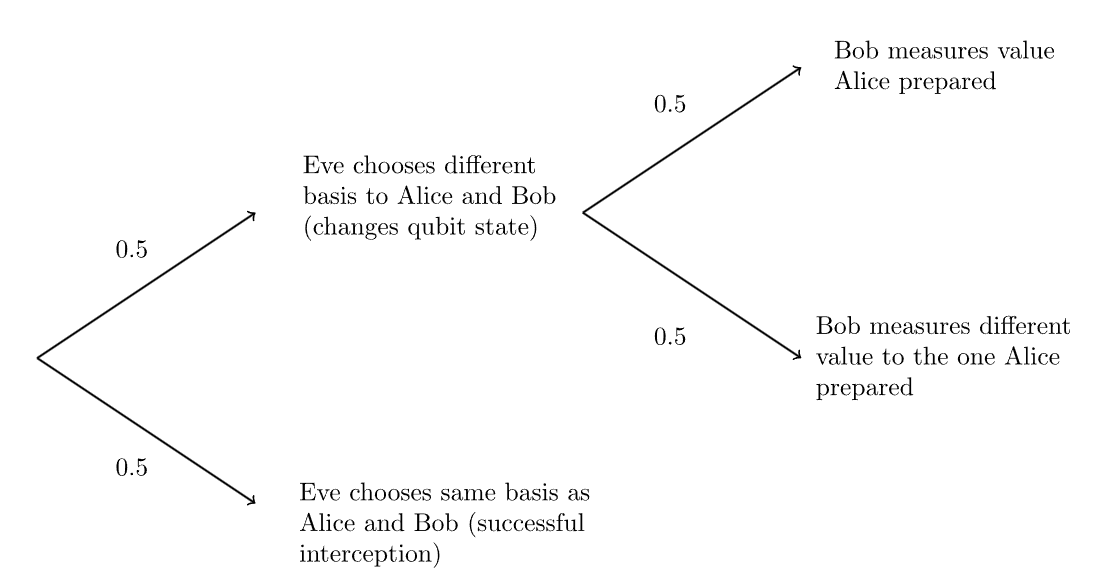 -->
<img src="https://learn.qiskit.org/content/v2/ch-algorithms/images/qkd_risk.svg" style="background-color: white" width="400">
<sup style="color:gray">Source: Qiskit Documentation</sup>

<br>
<hr>

## Implementation: Quantum Key Distribution
This is a functioning demonstration of the QKD protocol, implemented upon the IBM-developed open-source Qiskit framework. It allows us to design and assemble quantum circuits and model the qubit states accurately. We have the option of using multiple backends, both hosted and local. The cloud-based backend give us access to actual quantum computers such as the `ibm_perth` system shown here. The free plan only allows for 10 minutes/month of system usage and we shall not be using it, as you'd guess by noticing the number of pending jobs there.

<!-- 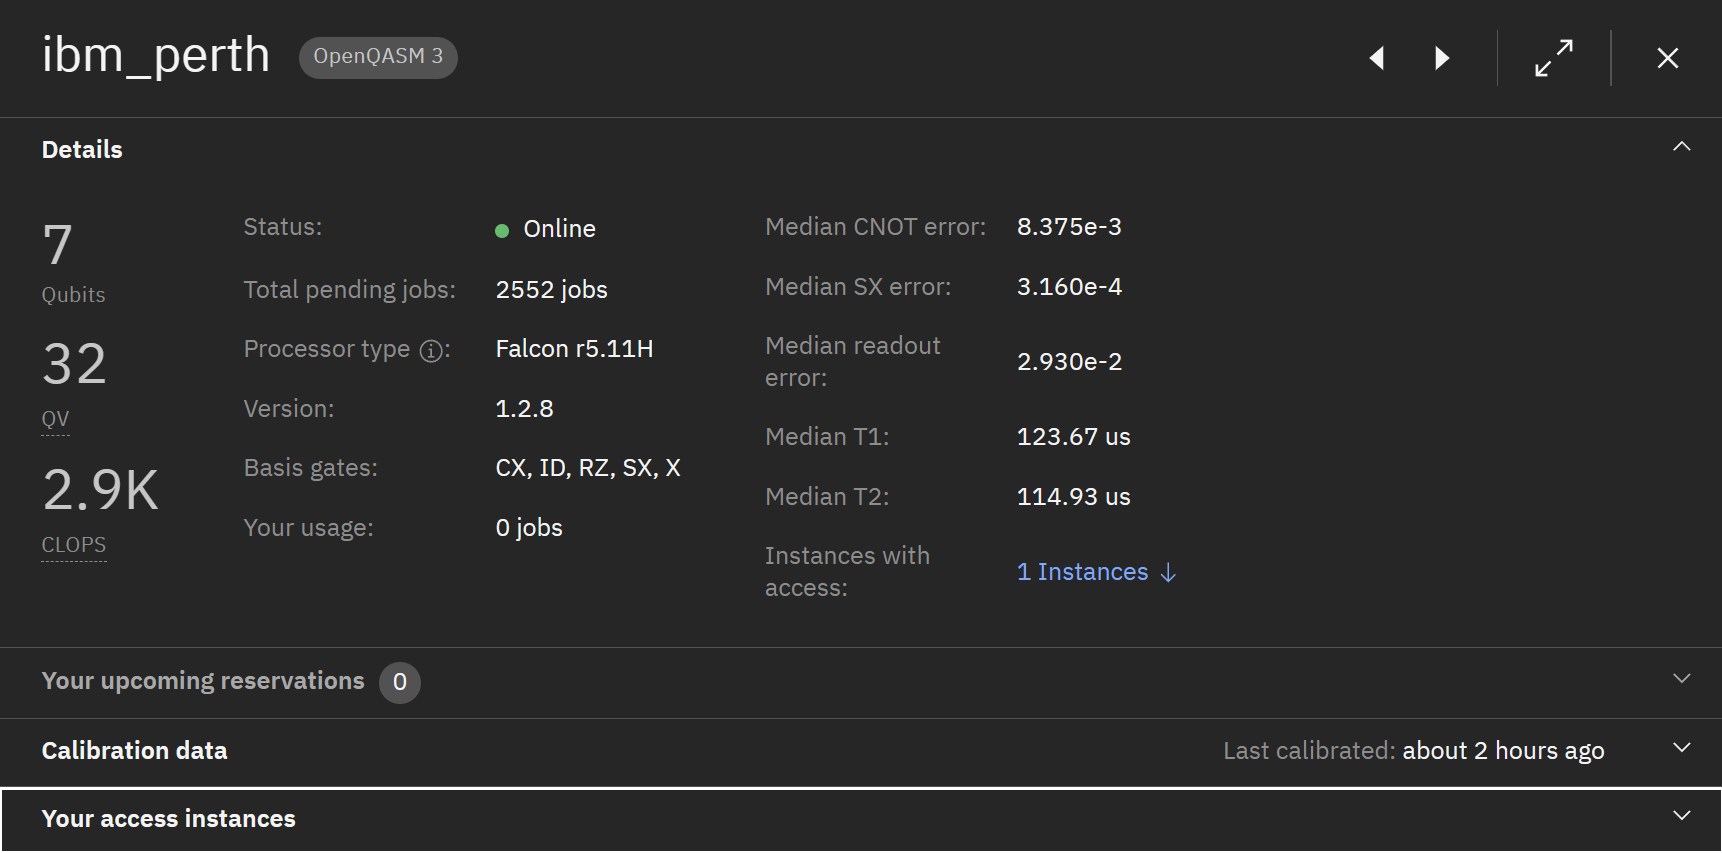 -->
<img src="https://media.discordapp.net/attachments/590611990506897474/1170667013585252352/image.png" width="500">
<sup style="color:gray">Source: Aarya Bodhankar via IBM Quantum Platform</sup>

We shall instead use Qiskit's Aer simulator which runs locally and has no usage limitations.

In [1]:
from qiskit import QuantumCircuit, Aer
from qiskit.visualization import circuit_drawer

import numpy as np
from numpy.random import randint

Encoding the message in `encode_message()` involves initialising a circuit to encode qubits in the Z and X bases depending on whether they hold the value of 0 or 1 respectively. Consider a basis to be an orientation of a qubit. Measurements done from different bases differ in their values.

In [2]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0:    # Z-basis encoding
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else:                # X-basis encoding
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message, qc

Visualising the quantum citcuit using `qiskit.visualization.circuit_drawer` with arbitrary values for bits and bases.

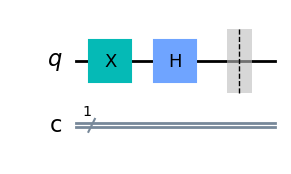

In [3]:
n = 10
qc_visual = encode_message(
                randint(2, size=10), 
                randint(2, size=10)
            )[1]
circuit_drawer(qc_visual, output='mpl')

The `X` here is the equivalent of the NOT Gate which flips the quantum state (such as from 0 to 1), while the `H` is Hadamard, a quantum-only gate which encodes the qubits in superposition (that is, a combination of the 0 and 1 states). `q` reporesents the qubit while `C` represents the bit.

The `measure_message()` function initialises the simulator which executes the circuits needed for basis measurements. Every qubit's measurement is stored in the `measurements` list.

In [4]:
def measure_message(message, bases):
    # backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In the complete qubit sequence of random bases, we only nedd the qubits having matching bases set by both Alice and Bob. These 'good bits' are saved by `remove_garbage()` while discarding the rest.

In [5]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            good_bits.append(bits[q])
    return good_bits

We need a sample of the qubit sequence to verify whether the key is valid and untampered, done by `sample_bits()` here. Note that the `pop()` operation here eliminates those qubits from the original sequence as well, which is necessary since those have been broadcasted for verification and are no longer secret.

In [6]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure that sampled bits always in list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element at index 'i', from the main list as well
        sample.append(bits.pop(i))
    return sample

Time to bring it all together! With `n` as the number of qubits in the sequence, `alice_bits` as the message (intended to serve as the key), and the basis sequences `alice_bases` and `bob_bases`, all the functions are invoked in their sequence.

In [7]:
n = 100

# Step 1: Set the qubit sequence to be transmitted, and the basis sequence to be used by Alice
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)

# Step 2: Encode the message from Alice's side using the quantum circuit defined before
message = encode_message(alice_bits, alice_bases)[0]

In [18]:
print(f'Message:\n{message[11]}')
print(f'Message:\n{message[0]}')
print(f'Message:\n{message[4]}')
print(f'Message:\n{message[7]}')

Message:
      ░ 
  q: ─░─
      ░ 
c: 1/═══
        
Message:
     ┌───┐ ░ 
  q: ┤ X ├─░─
     └───┘ ░ 
c: 1/════════
             
Message:
     ┌───┐ ░ 
  q: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════
             
Message:
     ┌───┐┌───┐ ░ 
  q: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c: 1/═════════════
                  


You can see above, the various circuits used to measure qubits in different bases and states.

In [19]:
# Step 2/3: Interception by Eve
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(f'Intercepted message:\n{intercepted_message}')

Intercepted message:
[1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]


In [20]:
# Step 3: Message received and measured by Bob using his basis sequence
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

In [21]:
# Step 4: Discarding qubits with mismatched basis measurements
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

# Step 5: The number of qubits broadcasted to verify key integrity
sample_size = 10   # the lower the sample, the easier for Eve to go undetected
bit_selection = randint(n, size=sample_size)
print(f'Verification bits selected from key: {bit_selection}')

bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

Verification bits selected from key: [92 55 86 57 81 82 21 78 95 33]


In [22]:
# Checking whether the sample matches from both Alice and Bob's side

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


<hr>

## Implementation: AES
AES in Python is reliably implemented using the `cryptography` package. The AES module is `cryptography.hazmat.primitives.ciphers.algorithms.AES(key)` and accepts a key in the bytes format.

We are using `bob_key` here, with the assumption that interception did not take place, or failed. A successful interception simply requires both parties to reset the channel and messages to try again. Our key is currently in a binary list format, and needs to be converted into bytes format. For that, we are first converting it to the decimal format.

In [23]:
bob_key_str = ''.join(str(bit) for bit in bob_key)
bob_key_dec = int(bob_key_str, 2)
print(f'Decimal Key: {bob_key_dec}')

Decimal Key: 14761071855161


The key we have at hand is far smaller than the size needed for 128 or 256 bit encryption, so we employ an algorithm known as the Key Derivation Function to derive a fixed size key from the available arbitrary input.

An important argument here is `iterations` which specifies the rounds of one-way computation performed on the input key material; and the output of each iteration is fed as input to the next iteration. Iterations increase the computational effort required to derive the key, and thereby make it harder to brute force it as well.

In [24]:
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.backends import default_backend

original_key = bob_key_dec.to_bytes(8, byteorder='big')

desired_key_length = 32  # Length of resized key in bytes (128 bits)

kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=desired_key_length,
    salt=b'',
    iterations=100000,
    backend=default_backend()
)

resized_key = kdf.derive(original_key)
resized_key

b'\x01U\xe8]a!\xcf\xb3\xc8\x1c\t\xee\x97\x87#\xc4\x0c_>P\xef(\xe4~\xa6\xfe"=o\xc5\xf1s'

Lastly, we use this new QKD-verified KDF-expanded byte-format key to encrypt our message using Rijndael aka AES!

In [25]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding

import os


# Initialising the AES cipher object with expanded key and mode
cipher = Cipher(algorithms.AES(resized_key), modes.ECB(), backend=default_backend())

encryptor = cipher.encryptor()
decryptor = cipher.decryptor()

# Encrypt plaintext
plaintext = b'Something Awesome? Something Unique!'

# padding added to fit the plaintext to the fixed block lengths required by AES
padder = padding.PKCS7(128).padder()
padded_plaintext = padder.update(plaintext) + padder.finalize()

ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
print("Ciphertext:", ciphertext)

# Decrypt ciphertext
unpadder = padding.PKCS7(128).unpadder()
unpadded_ciphertext = decryptor.update(ciphertext) + decryptor.finalize()
decrypted = unpadder.update(unpadded_ciphertext) + unpadder.finalize()
print("Decrypted:", decrypted.decode('utf-8'))

Ciphertext: b'\xd1\x1c1\xd0n\xc2\x0e\xd0\xa5\xdd\x06x9\xc3\x90\xaf\x94\xc9\xcc\xf3\xb5b\xa77~+[_\x08=Xg7w,\x91\x92\x93\xf1\xc5\xd0\xea4o\xc2xyt'
Decrypted: Something Awesome? Something Unique!


### Conclusion
Thus we have generated a key using Quantum Key Distribution, verified it over the channel for interception and tampering, processed it using Key Derivation Function to make it suitably sized, and utilised it in AES to encrypt and decrypt messages.

This project taught us the concept of QKD and how quantum properties enable tamper evident protocols. It successfully demonstrated that quantum techniques are not limited to theoretical concepts and can be actively integrated with mainstream protocols and systems to enhance security and reliability.